## gather mutltiview samples

In [1]:
from capture_utils import *

Pixel format set to RGB8
IC4 Grabber and Sink initialized.


In [2]:
# cv2.imshow('frame', cap.read()[1])
# cv2.imwrite('test.png', cap.read()[1])
# plt.imshow(cap.read()[1])
# plt.show()
# cv2.waitKey(0)




showing


Capturing frames:  64%|██████▍   | 639/1000 [01:31<00:51,  7.00it/s]


[[40]]


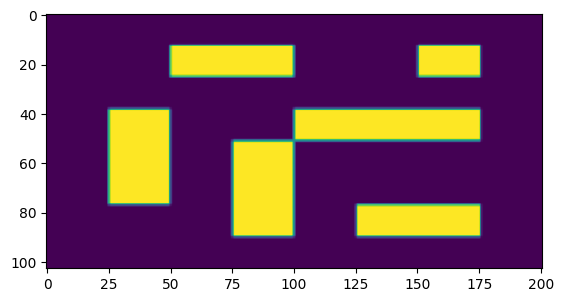

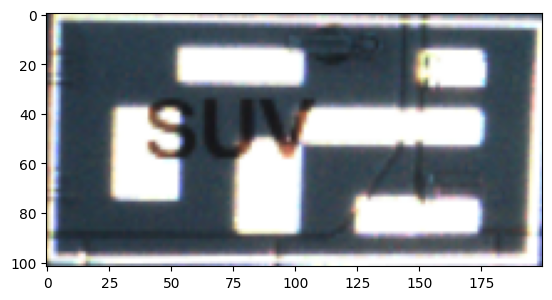

In [3]:
display_drawer()
run_aruco_detector()


In [ ]:
photometric_calibration()

In [ ]:
import adv_optimization_utils as adv



In [ ]:
adv.optimize_patch()

In [ ]:
import torch
from classfier import *
res_dir = './results/'
# chose most recent result
import os
results = os.listdir(res_dir)
results = [r for r in results if 'working_patch_' in r]
results = sorted(results, key=lambda x: os.path.getmtime(os.path.join(res_dir, x)))
load_path = res_dir + results[-1]
print('loading from:', load_path)
all_patchs_results = os.listdir(res_dir)
all_patchs_results = [r for r in all_patchs_results if 'working_patchs_all_multiview' in r]
all_patchs_results = sorted(all_patchs_results, key=lambda x: os.path.getmtime(os.path.join(res_dir, x)))
load_path_all = res_dir + all_patchs_results[-1]
print('loading all from:', load_path_all)


In [ ]:
best_patchs_results = os.listdir(res_dir)
best_patchs_results = [r for r in best_patchs_results if 'best_patch_multiview_' in r]
best_patchs_results = sorted(best_patchs_results, key=lambda x: os.path.getmtime(os.path.join(res_dir, x)))
load_best_patch = res_dir + best_patchs_results[-1]
# patch = torchvision.io.read_image(load_best_patch)
patch = torch.load(load_best_patch)

In [ ]:
load_best_patch

In [ ]:
plot_on_screen(patch.cpu().permute(1,2,0).detach().numpy()*255)

In [ ]:
patchs = torch.load(load_path_all)#torch.load('./results/working_patchs_all_multiview_2025-09-18_00_20.pth')
tt = lambda x: torch.tensor(cv2.cvtColor(x, cv2.COLOR_BGR2RGB)/255.).permute(2,0,1).float()



In [ ]:
preds = []
found = False
good_patchs = []
for idx, pp in enumerate(patchs[1]):
    # if 'jeep'  in patchs[0][idx] or 'half track' in patchs[0][idx]:
    #     continue

    plot_on_screen(pp.cpu().permute(1,2,0).numpy()*255)
    for i in range(10):
        r = cap.read()[1]
        r = cv2.cvtColor(r, cv2.COLOR_BGR2RGB)
        tr = tt(r)
        res= resnet_predict(tr.cuda().unsqueeze(0))
        # add text
        cv2.putText(r, f'Pred: {res}', (10,30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0), 2)
        
        cv2.imshow('frame', cv2.cvtColor(r, cv2.COLOR_BGR2RGB))
        preds.append(res)
        plt.imshow(r)
        plt.show()
        IPython.display.clear_output(wait=True)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
        if 'jeep' not in res and 'half track' not in res:
            found = True
            break
    if found:
        good_patchs.append(pp)
        

In [ ]:
plot_on_screen(good_patchs[0].cpu().permute(1,2,0).numpy()*255)

In [ ]:
# pred_pairs = list(zip(patchs[0], range(len(patchs[0]))))
# print(pred_pairs)
# for p in pred_pairs:
#     if p[0] != 'jeep' and p[0] != 'half track':       
#         print(p[0])
#         patch = patchs[1][p[1]]
#         break


In [ ]:


# patch = torch.load('./results/working_patch_multiview_2025-09-17_07:23.pth')
# tt = lambda x: torch.tensor(cv2.cvtColor(x, cv2.COLOR_BGR2RGB)/255.).permute(2,0,1).float()
# patch = torch.load(load_path)
# plot_on_screen(patch.cpu().permute(1,2,0).numpy()*255)

In [ ]:
# best_patch_path = r'./results/best_patch_multiview_2025-09-23_21_19.pth'#r"C:\git\PhysicalAdverserialProj\results\best_patch_26_2025-09-21_01_14.png"

In [ ]:
best_patch = torch.load(best_patch_path)
plot_on_screen(best_patch.cpu().permute(1,2,0).detach().numpy()*255)

In [4]:
plot_on_screen(cv2.cvtColor(cv2.imread(r'./results/best_patch_10_2025-09-23_22_32.png'), cv2.COLOR_BGR2RGB))

In [9]:
from classfier import *

tt = lambda x: torch.tensor(cv2.cvtColor(x, cv2.COLOR_BGR2RGB)/255.).permute(2,0,1).float()

caps = []
results = []
for i in range(1000):
    r = cap.read()[1]
    tr = tt(r)
    # res= resnet_predict(tr.cuda().unsqueeze(0))
    with torch.no_grad():
        p = model(preprocess(tr).unsqueeze(0).to('cuda'))
        res = weights.meta["categories"][p[0].argmax(0).item()]
        prob = p[0].max(0).values.item()
    print(res)
    # add text
    cv2.putText(r, f'Pred: {res}: {prob:.2f}%', (10,30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0), 2)
    cv2.imshow('frame', r)
    results.append(res)

    caps.append(r)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break


digital clock
digital clock
digital clock
digital clock
digital clock
digital clock
digital clock
digital clock
digital clock
digital clock
digital clock
digital clock
digital clock
digital clock
digital clock
digital clock
digital clock
digital clock
digital clock
jeep
digital clock
digital clock
digital clock
digital clock
digital clock
digital clock
digital clock
digital clock
digital clock
digital clock
digital clock
digital clock
digital clock
digital clock
digital clock
digital clock
digital clock
digital clock
digital clock
digital clock
digital clock
digital clock
digital clock
digital clock
digital clock
digital clock
digital clock
digital clock
digital clock
digital clock
digital clock
jeep
jeep
digital clock
digital clock
digital clock
digital clock
digital clock
digital clock
limousine
digital clock
digital clock
digital clock
digital clock
digital clock
digital clock
jeep
digital clock
digital clock
digital clock
digital clock
digital clock
digital clock
digital clock
digi

In [10]:
video_name = 'captured_video_jeep4.avi'
height, width, layers = caps[0].shape
video = cv2.VideoWriter(video_name, 0, 30, (width,height))
for captured in caps:
    video.write(captured)

In [ ]:

import torch
import torch.nn as nn
import torchvision.models as models

import glob
import tqdm
import matplotlib.pyplot as plt
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import cv2
import time
import time
from tqdm import tqdm
import copy
from IPython.display import display, Image, clear_output
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import datetime


import cv2
import os
import glob


import kornia
import tqdm

import torchvision

tt = torchvision.transforms.ToTensor()

import cv2
import cv2.aruco as aruco
import numpy as np

from classfier import *

import pickle as pkl

with open("photometric_calibration.pkl", "rb") as f:
    data = pkl.load(f)

height = data['height']
width = data['width']

resizer = torchvision.transforms.Resize((height, width))
device = 'cuda' if torch.cuda.is_available() else 'cpu'


# Define parameters for ArUco marker detection
aruco_dict_type = cv2.aruco.DICT_6X6_250 # Change dictionary type if needed
marker_length = 0.05  # Marker length in meters (adjust as needed)
aruco_dict = cv2.aruco.getPredefinedDictionary(aruco_dict_type)

marker_id = 40
marker_size = 500  # Size in pixels
marker_image = cv2.aruco.generateImageMarker(aruco_dict, marker_id, marker_size)


aruco_dict = aruco.getPredefinedDictionary(aruco_dict_type)
parameters = aruco.DetectorParameters()

# Detect ArUco markers
detector = aruco.ArucoDetector(aruco_dict, parameters)


from diffusers import StableDiffusionPipeline
import torch

# Load stable diffusion model


def decode_latents_grad(latents):
    # latents = F.interpolate(latents, (64, 64), mode='bilinear', align_corners=False)
    latents = 1 / 0.18215 * latents

    imgs = vae.decode(latents).sample

    imgs = (imgs / 2 + 0.5).clamp(0, 1)

    return imgs

def decode_latents(latents):
    # latents = F.interpolate(latents, (64, 64), mode='bilinear', align_corners=False)
    with torch.no_grad():
        with torch.amp.autocast(device):
            latents = 1 / 0.18215 * latents

            with torch.no_grad():
                imgs = vae.decode(latents).sample

            imgs = (imgs / 2 + 0.5).clamp(0, 1)

    return imgs

def encode_imgs(imgs):
    # imgs: [B, 3, H, W]
    with torch.no_grad():
        with torch.amp.autocast(device):
            imgs = 2 * imgs - 1

            posterior = vae.encode(imgs).latent_dist
            latents = posterior.sample() * 0.18215

    return latents



class framesDataset(Dataset):
    def __init__(self, frames, Hs):
        self.frames = frames
        self.Hs = Hs

    def __len__(self):
        return len(self.frames)

    def __getitem__(self, idx):
        frame = self.frames[idx]
        H = self.Hs[idx]

        # Convert to tensor and normalize
        frame_tensor = tt(frame)

        return frame_tensor, H.astype(np.float32)
    





def warp(decoded_latents,H_t):
    dst_img_shape = valid_frames[0].shape[:2]
    warped_imgs = []
    for decoded_latent in decoded_latents:
        img = decoded_latent.unsqueeze(0).float().repeat(H_t.shape[0], 1, 1, 1)
        w=  kornia.geometry.transform.warp_perspective(img, H_t, dst_img_shape)
        warped_imgs.append(w)
    return torch.stack(warped_imgs, dim=0)#.squeeze(1)


vae = None
valid_frames = None

os.makedirs('./results', exist_ok=True)
curr_without_sec = datetime.datetime.now().strftime("%Y-%m-%d %H:%M")
curr_without_sec = curr_without_sec.replace(" ", "_").replace(":", "_")




pipe = StableDiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4")

vae =  pipe.vae.to(device).eval()

latent = (torch.rand((4*4*4,4, 4, 4), device=device) - 0.5) * 2

# latent = torch.load(r"C:\git\PhysicalAdverserialProj\results\working_latent_multiview_2025-09-15_20").to(device)
latent = latent.clone().detach()
with torch.no_grad():
    decoded_latents = resizer(decode_latents(latent))


l_size_h = decoded_latents.shape[-2]
l_size_w = decoded_latents.shape[-1]

# Track running mean loss per latent/patch across batches
num_latents = latent.shape[0]

orig_img_corners = np.array([[0,0],[l_size_w,0],[l_size_w,l_size_h],[0,l_size_h]], dtype=np.float32)


border_size = 0

ls = os.listdir('.')
captures = [f for f in ls if f.startswith('captures_frames_multiview_') ]
cap_dir = f'captures_frames_multiview_{len(captures)-1}'
print('using capture dir', cap_dir)

valid_frame_paths = glob.glob(f'{cap_dir}/*.png')

valid_frames = []

Hs = []

for path in tqdm.tqdm_notebook(valid_frame_paths):
    img = cv2.imread(path)
    # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    corners, ids, _ = detector.detectMarkers(gray)

    with torch.no_grad():
        pr = resnet_predict_raw(tt(img).cuda().unsqueeze(0))

    if ids is not None and pr.argmax(1) in orig_clases:

        c = corners[0][0]
        unbordred_corners = np.array([[c[0][0]-border_size, c[0][1]+border_size],
                            [c[1][0]-border_size, c[1][1]-border_size],
                            [c[2][0]+border_size, c[2][1]-border_size],
                            [c[3][0]+border_size, c[3][1]+border_size]])

        dst_pts = unbordred_corners
        H, _ = cv2.findHomography(orig_img_corners, dst_pts, cv2.RANSAC)

        Hs.append(H)
        valid_frames.append(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

print(f"Found {len(valid_frames)} valid frames with ArUco markers and original classes.")


num_of_frames_for_training = 10
print(f"Using {num_of_frames_for_training} frames for training.")

random_valid_frames_subset = np.random.choice(len(valid_frames), min(num_of_frames_for_training, len(valid_frames)), replace=False)
valid_frames = [valid_frames[i] for i in random_valid_frames_subset]
Hs = [Hs[i] for i in random_valid_frames_subset]


ds = framesDataset(valid_frames, Hs)


print('creating dataloader')
train,val,test = torch.utils.data.random_split(ds, [int(len(ds)*0.8), int(len(ds)*0.1), int(len(ds)*0.1)])
train_loader = DataLoader(train, batch_size=1, shuffle=True)#, num_workers=2, persistent_workers=True)
val_loader = DataLoader(val, batch_size=len(val), shuffle=False)#, num_workers=2, persistent_workers=True)
test_loader = DataLoader(test, batch_size=10, shuffle=False)#, num_workers=2, persistent_workers=True)

print('dataloader created')
    
# latent.requires_grad = True

latent_batch_size = 64


latent_batches = torch.split(latent, latent_batch_size)

for idx,latent_batch in enumerate(latent_batches):
    latent_batch.requires_grad = True

lrs = [10 * 10**(-1 * idx) for idx in range(len(latent_batches))]
latent_opts = [torch.optim.Adam([latent_batch], lr=lrs[idx]) for idx,latent_batch in enumerate(latent_batches)]





jitter = T.ColorJitter(brightness=0.1,contrast=0.1,saturation=0.1)
jitter_total_photo = T.ColorJitter(brightness=0.1,contrast=0.1,saturation=0.1)
jitter_with_hue = T.ColorJitter(brightness=0.5,contrast=0.5,saturation=0.5,hue=0.1)

augmentor = data['augmentor'].to(device).eval()
mapper = lambda x: jitter(augmentor(x))
# mapper = lambda x: jitter(x)

print('starting optimization')
i = -1
# blend_ratio = 1
for epoch in range(5000):
    for latent_opt in latent_opts:
            latent_opt.zero_grad()

    for frames, H_t in tqdm.tqdm(train_loader):
        i += 1


        for latent_batch, latent_opt in zip(latent_batches, latent_opts):

            # adv_loss = lbfgs_latent_opt.step(latent_closure_adp)

            frames = frames.to('cuda')

            blend_ratio = torch.rand(1).cuda() * 0.2 + 0.8
            stronger_aug_steps_thresh = 400
            
            if i == stronger_aug_steps_thresh:
                print('using stronger augmentations')

            if i < stronger_aug_steps_thresh:
                mapper = lambda x: jitter(x)

            else:
                mapper = lambda x: jitter(torch.stack([augmentor(xx).to(device) for xx in x]))

            adv_patch = resizer(decode_latents_grad(latent_batch).float())

            adv_patch_m = mapper(adv_patch)

            # w_mask  =warp(adv_patch_m*0+1)
            # w  =warp(adv_patch_m)
            w_mask  =warp(adv_patch_m*0+1, H_t.cuda())
            w  = warp(adv_patch_m, H_t.cuda())

            sum_tensor = ((w_mask != 0) * -blend_ratio + 1) * frames + w *blend_ratio

            sum_tensor = sum_tensor.view(sum_tensor.shape[0]*sum_tensor.shape[1], sum_tensor.shape[2], sum_tensor.shape[3], sum_tensor.shape[4])

            sum_tensor = jitter_total_photo(sum_tensor)

            # Compute vector of losses per composed image, then mean for optimization
            adv_loss =  adv_loss_calc2(sum_tensor).mean() #+ adv_patch.norm() / 10000
            
            raise
            adv_loss.backward()

            if i % 10 == 0:
                latent_opt.step()
        
        if i % 50 == 0:
        #     with torch.no_grad():

        #         weight = 0.5

        #         frames, H_t = next(iter(val_loader))
        #         frames = frames.to('cuda')

        #         w_mask  =warp(adv_patch_m*0+1, H_t.cuda())
        #         w  = warp(adv_patch_m, H_t.cuda())
        #         sum_tensor = ((w_mask != 0) * -blend_ratio + 1) * frames + w *blend_ratio
        #         sum_tensor = sum_tensor.view(sum_tensor.shape[0]*sum_tensor.shape[1], sum_tensor.shape[2], sum_tensor.shape[3], sum_tensor.shape[4])
        #         sum_tensor = jitter_total_photo(sum_tensor)
        #         loss = adv_loss_calc2(sum_tensor)

            
        #         # Rejuvenation based on running mean loss per patch: choose best (lowest loss) as donor
        #         preds = resnet_predict_raw(sum_tensor).argmax(1)
        #         orig = torch.as_tensor(orig_clases, device=preds.device)
        #         is_orig = torch.isin(preds, orig)

        #         unsuccess_idx = torch.nonzero(is_orig, as_tuple=False).squeeze(1)
        #         success_idx = torch.nonzero(~is_orig, as_tuple=False).squeeze(1)

        #         if unsuccess_idx.numel() > 0:
        #             # Map flattened image indices back to latent indices (handles batch>1 robustly)
        #             current_total_imgs = sum_tensor.shape[0]
        #             images_per_latent = max(1, current_total_imgs // num_latents)
        #             unsuccess_lat_idx = torch.div(unsuccess_idx, images_per_latent, rounding_mode='floor')
        #             unsuccess_lat_idx = torch.clamp(unsuccess_lat_idx, max=num_latents - 1)
                    

        #             # display patchs in a grid
        #             plt.figure(figsize=(12,12))
        #             plt.imshow(torchvision.utils.make_grid(decoded_latents.float().cpu(), nrow=6).permute(1,2,0).numpy())
        #             plt.axis('off')
        #             plt.show()
        #             print('replacing latents:', unsuccess_lat_idx.unique().cpu().numpy())


        #             if (success_idx.numel() > 0):
        #                 print('found successful patches to copy from:', success_idx.numel())
        #                 success_lat_idx = torch.div(success_idx, images_per_latent, rounding_mode='floor')
        #                 success_lat_idx = torch.clamp(success_lat_idx, max=num_latents - 1)
        #                 random_donor_idxs_choise = torch.randint(0, success_lat_idx.numel(), (unsuccess_lat_idx.numel(),), device=success_lat_idx.device)
        #                 random_donor_idxs = success_lat_idx[random_donor_idxs_choise]
        #                 donor_latent = latent[random_donor_idxs]
                    
        #             else:
        #                 print('no successful patches to copy from, using best of current batch')
        #                 best_patch_idx = torch.argmin(loss)
        #                 donor_lat_idx = torch.div(best_patch_idx, images_per_latent, rounding_mode='floor')
        #                 donor_lat_idx = torch.clamp(donor_lat_idx, max=num_latents - 1)
        #                 donor_latent = latent[donor_lat_idx]
        #                 donor_latent = donor_latent.unsqueeze(0)


                    # noise = torch.randn((unsuccess_lat_idx.numel(), *latent.shape[1:]), device=latent.device) * 0.5
                    
                    # latent[unsuccess_lat_idx] = latent[unsuccess_lat_idx] * weight + (1-weight) * latent[unsuccess_lat_idx]
                    # latent[unsuccess_lat_idx] = latent[unsuccess_lat_idx].copy_(donor_latent)




                    # Reset running loss stats

                    decoded_latents = resizer(decode_latents(latent))
                    print('latent replaced, decoded new patch:')
                    plt.figure(figsize=(12,12))
                    plt.imshow(torchvision.utils.make_grid(decoded_latents.float().cpu(), nrow=6).permute(1,2,0).numpy())
                    plt.axis('off')
                    plt.show()


                # Recreate optimizer to reset state after latent replacements
                # lr = 0.1
                # if isinstance(latent_opt, torch.optim.Optimizer) and len(latent_opt.param_groups) > 0:
                #     lr = latent_opt.param_groups[0].get('lr', lr)
                # latent_opt = torch.optim.Adam([latent], lr=lr)

        if i % 200 == 0:
            # print(f"Iteration {i}, Loss: {latent_closure_adp().item():.4f}")
            print(f"Iteration {i}, Loss: {adv_loss.item():.4f}" )# grad_norm: {latent.grad.norm().item():.4f}")

            with torch.no_grad():
                # Track the best patch across the entire validation step
                best_val_loss = None
                best_val_patch = None
                best_val_patch_idx = None

                for frames, H_t in tqdm.tqdm(test_loader):
                    for lat_idx, latent_batch in enumerate(torch.split(latent, latent_batch_size)):
                        adv_patch = resizer(decode_latents(latent_batch).float())

                        # adv_patch = resizer(decode_latents(latent).float())

                        frames = frames.to('cuda')

                        
                        adv_patch_m = mapper(adv_patch)

                        # w_mask  =warp(adv_patch_m*0+1)
                        # w  =warp(adv_patch_m)
                        w_mask  =warp(adv_patch_m*0+1, H_t.cuda())
                        w  = warp(adv_patch_m, H_t.cuda())

                        sum_tensor = ((w_mask != 0) * -blend_ratio + 1) * frames + w *blend_ratio

                        sum_tensor = sum_tensor.view(sum_tensor.shape[0]*sum_tensor.shape[1], sum_tensor.shape[2], sum_tensor.shape[3], sum_tensor.shape[4])

                        sum_tensor = jitter_total_photo(sum_tensor)

                        val_losses = adv_loss_calc2(sum_tensor)

                        sum_tensor = sum_tensor.cpu()
                        argmin = torch.argmin(val_losses).cpu().item()

                        # Map best composed image to its latent index within this batch
                        current_total_imgs = val_losses.numel()
                        images_per_latent = max(1, current_total_imgs // adv_patch.shape[0])
                        batch_best_lat_idx = argmin // images_per_latent

                        # Update global best over validation
                        min_loss_value = val_losses.view(-1)[argmin].detach().cpu().item()
                        if (best_val_loss is None) or (min_loss_value < best_val_loss):
                            best_val_loss = min_loss_value
                            best_val_patch_idx = int(batch_best_lat_idx)
                            best_val_patch = adv_patch[best_val_patch_idx].detach().cpu()

                        plt.imshow(sum_tensor[argmin].permute(1,2,0).numpy())
                        plt.show()
                        print(resnet_predict(sum_tensor[argmin].unsqueeze(0).cuda()))

                        test_pred = resnet_predict(sum_tensor.cuda())
                        if type(test_pred) == list:
                            pred = resnet_predict(sum_tensor.cuda())
                            print(np.unique(pred,return_counts=True))

                        break
                    break
                    # print(lx)

                # Save the latent state
                out_path =  rf'./results/working_latent_multiview_{curr_without_sec}.pth'
                torch.save(latent.cpu().detach(), out_path)
                print('saved latent to', out_path)
                out_path =  rf'./results/working_patch_multiview_{curr_without_sec}.pth'
                # torch.save(adv_patch[argmin// sum_tensor.shape[0]].cpu().detach(), out_path)
                # print('saved patch to', out_path)
                # Save best validation patch separately
                if best_val_patch is not None:
                    best_patch_path = rf'./results/best_patch_multiview_{curr_without_sec}.pth'
                    torch.save(best_val_patch, best_patch_path)
                    print(f'saved best validation patch (idx={best_val_patch_idx}, loss={best_val_loss:.4f}) to', best_patch_path)
                out_path =  rf'./results/working_patchs_all_multiview_{curr_without_sec}.pth'
                torch.save((pred,adv_patch.cpu().detach()), out_path)
                print('saved patch to', out_path)




In [ ]:
plt.imshow(frames[0].permute(1,2,0).cpu().numpy())

In [ ]:
latent_batch = torch.rand((30,4, 4, 4), device=device) * 2 -1
latent_batch.requires_grad = True
latent_opt = torch.optim.Adam([latent_batch], lr=0.001)

In [ ]:
frames.shape

In [ ]:
for wwi in range(1000):
            frames = frames.to('cuda')

            blend_ratio = torch.rand(1).cuda() * 0.2 + 0.8
            stronger_aug_steps_thresh = 400
            
            if i == stronger_aug_steps_thresh:
                print('using stronger augmentations')

            mapper = lambda x: x
            # if i < stronger_aug_steps_thresh:
            #     mapper = lambda x: jitter(x)

            # else:
            #     mapper = lambda x: jitter(torch.stack([augmentor(xx).to(device) for xx in x]))

            adv_patch = resizer(decode_latents_grad(latent_batch).float())

            adv_patch_m = mapper(adv_patch)

            # w_mask  =warp(adv_patch_m*0+1)
            # w  =warp(adv_patch_m)
            w_mask  =warp(adv_patch_m*0+1, H_t.cuda())
            w  = warp(adv_patch_m, H_t.cuda())

            sum_tensor = ((w_mask != 0) * -blend_ratio + 1) * frames + w *blend_ratio

            sum_tensor = sum_tensor.view(sum_tensor.shape[0]*sum_tensor.shape[1], sum_tensor.shape[2], sum_tensor.shape[3], sum_tensor.shape[4])

            sum_tensor = jitter_total_photo(sum_tensor)

            # Compute vector of losses per composed image, then mean for optimization
            # adv_loss =  adv_loss_calc(sum_tensor).mean() #+ adv_patch.norm() / 10000
            # rp = resnet_predict_raw(sum_tensor.cuda())
            # adv_loss = rp[:,409].sum() * -1
            batch = preprocess(sum_tensor)
            orig_clases_one_hot = torch.zeros((1000,), device='cuda')
            orig_clases_one_hot[orig_clases] = 1
            # Get probabilities for original classes
            p = model(batch)

            
            orig_probs = torch.softmax(p, dim=1) @ orig_clases_one_hot
            other_probs= torch.softmax(p, dim=1) @ (orig_clases_one_hot==0).float()
            # # Loss: maximize the negative log-probability of original classes
            adv_loss = (orig_probs - other_probs).mean()

  # Step 4: Use the model and print the predicted category
            
            adv_loss.backward()

            latent_opt.step()

            print(adv_loss.item())
            with torch.no_grad():
                preds = resnet_predict(sum_tensor.cuda())
                preds_raw = resnet_predict_raw(sum_tensor.cuda()).argmax(1)
                for pred in preds_raw:
                       if pred not in orig_clases:
                           print('success', pred)
                           raise
                print(np.unique(preds,return_counts=True))

In [ ]:
adv_loss.shape

In [ ]:
with torch.no_grad():
            batch = preprocess(sum_tensor)

            p = model(batch)

In [ ]:
orig_clases

In [ ]:
orig_clases_one_hot = torch.zeros((1000,), device='cuda')
orig_clases_one_hot[orig_clases] = 1
ce_loss = torch.nn.CrossEntropyLoss()
ce_orig_classes_loss = lambda x: ce_loss(x, orig_clases_one_hot.unsqueeze(0).repeat(x.shape[0],1))

In [ ]:
    batch = preprocess(sum_tensor)
    p = model(batch)

    # Get probabilities for original classes
    orig_probs = torch.softmax(p, dim=1) @ orig_clases_one_hot

    # Loss: maximize the negative log-probability of original classes
    loss = -torch.log(orig_probs + 1e-10)

In [ ]:
with torch.no_grad():
    rp = resnet_predict_raw(sum_tensor.cuda())
    rp[:,609].sum()

In [ ]:
with torch.no_grad():
    l = adv_loss_calc2(sum_tensor)

In [ ]:
with torch.no_grad():
    print(resnet_predict(sum_tensor[0].unsqueeze(0).cuda()))
    pp = resnet_predict_raw(sum_tensor[0].unsqueeze(0).cuda())

In [ ]:
res_df = pd.DataFrame([pp[0].cpu().numpy(),np.arange(1000)]).T
res_df.columns = ['pred','idx']

In [ ]:
cat = weights.meta["categories"]

In [ ]:
res_df['cat'] = res_df['idx'].apply(lambda x: cat[int(x)])

In [ ]:
res_df.sort_values('pred', ascending=False).head(30)

In [ ]:
l.min()

In [ ]:
l.argmin()

In [ ]:
orig_clases

In [ ]:
plt.imshow(sum_tensor[13].permute(1,2,0).detach().cpu().numpy())

In [ ]:
latent.shape

In [ ]:
latent_np = latent.flatten(1).cpu().detach().numpy()

In [ ]:
latent_np_inv = np.linalg.inv(latent_np)

In [ ]:
with torch.no_grad():
        
    adv_patch = resizer(decode_latents_grad(latent).float())

    adv_patch_m = mapper(adv_patch)

    # w_mask  =warp(adv_patch_m*0+1)
    # w  =warp(adv_patch_m)
    w_mask  =warp(adv_patch_m*0+1, H_t.cuda())
    w  = warp(adv_patch_m, H_t.cuda())
    sum_tensor = ((w_mask != 0) * -blend_ratio + 1) * frames + w *blend_ratio

    sum_tensor = sum_tensor.view(sum_tensor.shape[0]*sum_tensor.shape[1], sum_tensor.shape[2], sum_tensor.shape[3], sum_tensor.shape[4])

    sum_tensor = jitter_total_photo(sum_tensor)
    patches_loses = adv_loss_calc2(sum_tensor)

    print(patches_loses)

In [ ]:
patches_loses

In [ ]:
patches_loses_np = patches_loses.cpu().detach().numpy()

In [ ]:
v = latent_np_inv @ patches_loses_np

In [ ]:
patches_loses[1]

In [ ]:
latent_np[0] @ v

In [ ]:
# Compute an orthonormal basis for the subspace orthogonal to v
import numpy as np

# Ensure v is a 1D numpy array
v_np = np.asarray(v).reshape(-1)

if not np.any(v_np):
    raise ValueError("v is the zero vector; every vector is orthogonal to v (orthogonal space is all of R^n).")

# Use SVD to find null space of v^T (i.e., all x such that v·x = 0)
# For A = [v]^T (1 x n), A = U S Vh, the null space basis are the columns of V corresponding to zero singular values.
A = v_np[None, :]  # shape (1, n)
U, S, Vh = np.linalg.svd(A, full_matrices=True)
rank = (S > 1e-12).sum()
# Columns of V (i.e., rows of Vh transposed) after the first 'rank' columns span the orthogonal complement
V = Vh.T
orth_basis = V[:, rank:]  # shape (n, n-rank) = (n, n-1)

print(f"Dimension of orthogonal space: {orth_basis.shape[1]} (in R^{orth_basis.shape[0]})")
# Quick verification: each basis vector should be orthogonal to v
check = np.abs(orth_basis.T @ v_np)
print("Max |dot(vi, v)| across basis:", float(check.max()))

# Optional: projector onto the orthogonal complement of v
vv = np.dot(v_np, v_np)
P_orth = np.eye(v_np.size) - np.outer(v_np, v_np) / vv  # Projects any vector onto v^⊥

# Example usage:
# x = np.random.randn(v_np.size)
# x_orth = P_orth @ x  # x_orth is orthogonal to v
# print(np.dot(x_orth, v_np))  # ~0


In [ ]:
orth_basis

In [ ]:
cand = orth_basis.reshape(63,4,4,4)

In [ ]:
with torch.no_grad():
    cand_decoded = resizer(decode_latents(torch.tensor(cand).float().to(device)))

In [ ]:
plt.imshow(cand_decoded[62].float().permute(1,2,0).cpu().numpy())
plt.show()

In [ ]:
            weight = 0.5

            frames, H_t = next(iter(val_loader))
            frames = frames.to('cuda')

            w_mask  =warp(adv_patch_m*0+1, H_t.cuda())
            w  = warp(adv_patch_m, H_t.cuda())
            sum_tensor = ((w_mask != 0) * -blend_ratio + 1) * frames + w *blend_ratio
            sum_tensor = sum_tensor.view(sum_tensor.shape[0]*sum_tensor.shape[1], sum_tensor.shape[2], sum_tensor.shape[3], sum_tensor.shape[4])
            sum_tensor = jitter_total_photo(sum_tensor)
            loss = adv_loss_calc2(sum_tensor)

        
            # Rejuvenation based on running mean loss per patch: choose best (lowest loss) as donor
            with torch.no_grad():
                preds = resnet_predict_raw(sum_tensor).argmax(1)
                orig = torch.as_tensor(orig_clases, device=preds.device)
                is_orig = torch.isin(preds, orig)

                unsuccess_idx = torch.nonzero(is_orig, as_tuple=False).squeeze(1)
                success_idx = torch.nonzero(~is_orig, as_tuple=False).squeeze(1)

                if unsuccess_idx.numel() > 0:
                    # Map flattened image indices back to latent indices (handles batch>1 robustly)
                    current_total_imgs = sum_tensor.shape[0]
                    images_per_latent = max(1, current_total_imgs // num_latents)
                    unsuccess_lat_idx = torch.div(unsuccess_idx, images_per_latent, rounding_mode='floor')
                    unsuccess_lat_idx = torch.clamp(unsuccess_lat_idx, max=num_latents - 1)
                    

                    # display patchs in a grid
                    plt.figure(figsize=(12,12))
                    plt.imshow(torchvision.utils.make_grid(decoded_latents.float().cpu(), nrow=6).permute(1,2,0).numpy())
                    plt.axis('off')
                    plt.show()
                    print('replacing latents:', unsuccess_lat_idx.unique().cpu().numpy())


                    if (success_idx.numel() > 0):
                        success_lat_idx = torch.div(success_idx, images_per_latent, rounding_mode='floor')
                        success_lat_idx = torch.clamp(success_lat_idx, max=num_latents - 1)
                        random_donor_idxs_choise = torch.randint(0, success_lat_idx.numel(), (unsuccess_lat_idx.numel(),), device=success_lat_idx.device)
                        random_donor_idxs = success_lat_idx[random_donor_idxs_choise]
                        donor_latent = latent[random_donor_idxs]
                    
                    else:
                        best_patch_idx = torch.argmin(loss)
                        donor_lat_idx = torch.div(best_patch_idx, images_per_latent, rounding_mode='floor')
                        donor_lat_idx = torch.clamp(donor_lat_idx, max=num_latents - 1)
                        donor_latent = latent[donor_lat_idx]
                        donor_latent = donor_latent.unsqueeze(0)


In [ ]:
latent[unsuccess_lat_idx] = donor_latent * weight + (1-weight) * latent[unsuccess_lat_idx]

In [ ]:
# Find the 4x4x4 latent vector that minimizes the loss
import torch

# Ensure inputs are available
if 'patches_loses' not in globals():
    raise RuntimeError("'patches_loses' not found in the notebook scope.")
if 'latent' not in globals():
    raise RuntimeError("'latent' (shape [N,4,4,4]) not found in the notebook scope.")

# Normalize patches_loses to a 1D tensor
pl = patches_loses
if isinstance(pl, list):
    pl = torch.tensor(pl)
pl = pl.detach().float().view(-1)

num_latents = int(latent.shape[0])
if latent.ndim != 4 or latent.shape[1:] != (4,4,4):
    raise RuntimeError(f"Expected latent to have shape [N,4,4,4], got {tuple(latent.shape)}")

# Handle the general case where multiple composed images may be generated per latent
images_per_latent = max(1, pl.numel() // num_latents)

best_img_idx = int(torch.argmin(pl).item())
best_lat_idx = min(num_latents - 1, best_img_idx // images_per_latent)

best_4x4x4 = latent[best_lat_idx].detach().cpu()

print(f"Best latent index: {best_lat_idx} (images_per_latent={images_per_latent})")
print(f"Minimum loss value: {pl[best_img_idx].item():.6f}")

# The result: 4x4x4 tensor minimizing the observed loss
best_4x4x4